**<center><font size=5>Brain Tumor Detection</font></center>**

# Project Overview and Objectives

This project's primary goal was to develop a CNN model that could determine whether or not a patient had a tumor based on an MRI image.To train the model for this binary problem, I used some model architecture and weights. I justified the model's performance using accuracy as a metric, which is defined as:

$$
\text{Accuracy} = \left( \frac{\text{Number of correctly predicted images}}{\text{Total number of tested images}} \right) \times 100\%
$$

- **Training set**: The set used during the model training to adjust the hyperparameters.
- **Validation set**: The set while training, check the model’s performance to rule out the model memorizing the data in training, which still fails to learn the unseen data.
- **Testing set**: The small set that we don't touch for the whole training process at all. It's used for final model performance evaluation.

# Data Set Description

The problem was solved using Brain MRI Images for Brain Tumor Detection image data. It consists of two classes of MRI scans:

- **NO**: no tumor, encoded as 0
- **YES**: tumor, encoded as 1

# Setting up the Environment by Importing Libraries and Modules

In [1]:
import os
from os import listdir
import tensorflow as tf
from keras import layers
from keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D,GlobalAveragePooling2D, Flatten, Dense,Dropout
from keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import itertools
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from glob import glob
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img, img_to_array, load_img
from tensorflow.keras.preprocessing import image
from keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import MobileNet

get_ipython().magic(u'matplotlib inline')

C:\Users\User\AppData\Local\Temp\ipykernel_16768\3197202110.py:28: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic(u'matplotlib inline')


# Data Import and Preprocessing

In [2]:
image_Dirct='dataset/'

In [3]:
# Function to crop brain images

def crop_brain_contour(image, plot=False):

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    # Series of erosions and dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)
    # Find contours in thresholded image, then grab the largest one
    conntours = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    conntours = imutils.grab_contours(conntours)
    c = max(conntours, key=cv2.contourArea)
    # Find the extreme points
    ext_Left = tuple(c[c[:, :, 0].argmin()][0])
    ext_Right = tuple(c[c[:, :, 0].argmax()][0])
    ext_Top = tuple(c[c[:, :, 1].argmin()][0])
    ext_Bot = tuple(c[c[:, :, 1].argmax()][0])
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_Image = image[ext_Top[1]:ext_Bot[1], ext_Left[0]:ext_Right[0]]

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)

        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_Image)
        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()
    return new_Image

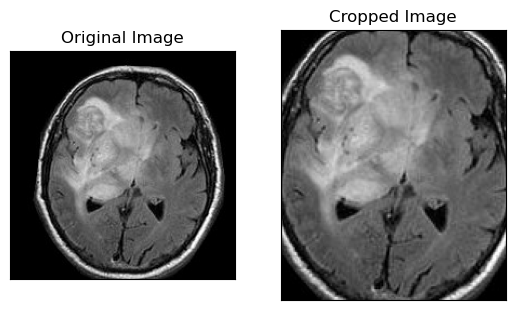

In [4]:
img = cv2.imread('yes/Y2.jpg')
new_img = crop_brain_contour(img, True)

# Data Loading

In [5]:
# Method to load data

def load_data(dirct_list, image_size):

    X = []
    y = []
    image_width, image_height = image_size
    for directory in dirct_list:
        for filename in listdir(directory):
            print(filename)
            print(directory)
            # load the image
            image = cv2.imread(directory + '/' + filename)
   
            # crop the brain and ignore the unnecessary rest part of the image
            image = crop_brain_contour(image, plot=False)
            # resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values to scale the input data to a consistent range between 0 and 1
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
    X = np.array(X)
    y = np.array(y)
    # Shuffle the data
    X, y = shuffle(X, y)
    print('Number of examples is:{}'.format(len(X)))
    return X,y

In [6]:
# Data loading from realdataset
yes_data = image_Dirct + 'yes'
no_data = image_Dirct + 'no'
img_Width, img_Height = (224, 224)
X, y = load_data([yes_data, no_data], (img_Width, img_Height))

Y1.jpg
dataset/yes
Y10.jpg
dataset/yes
Y100.JPG
dataset/yes
Y101.jpg
dataset/yes
Y102.jpg
dataset/yes
Y103.jpg
dataset/yes
Y104.jpg
dataset/yes
Y105.jpg
dataset/yes
Y106.jpg
dataset/yes
Y107.jpg
dataset/yes
Y108.jpg
dataset/yes
Y109.JPG
dataset/yes
Y11.jpg
dataset/yes
Y111.JPG
dataset/yes
Y112.JPG
dataset/yes
Y113.JPG
dataset/yes
Y114.JPG
dataset/yes
Y115.JPG
dataset/yes
Y116.JPG
dataset/yes
Y117.JPG
dataset/yes
Y12.jpg
dataset/yes
Y120.JPG
dataset/yes
Y13.jpg
dataset/yes
Y14.jpg
dataset/yes
Y146.JPG
dataset/yes
Y147.JPG
dataset/yes
Y148.JPG
dataset/yes
Y15.jpg
dataset/yes
Y153.jpg
dataset/yes
Y154.jpg
dataset/yes
Y155.JPG
dataset/yes
Y156.JPG
dataset/yes
Y157.JPG
dataset/yes
Y158.JPG
dataset/yes
Y159.JPG
dataset/yes
Y16.JPG
dataset/yes
Y160.JPG
dataset/yes
Y161.JPG
dataset/yes
Y162.jpg
dataset/yes
Y163.JPG
dataset/yes
Y164.JPG
dataset/yes
Y165.JPG
dataset/yes
Y166.JPG
dataset/yes
Y167.JPG
dataset/yes
Y168.jpg
dataset/yes
Y169.jpg
dataset/yes
Y17.jpg
dataset/yes
Y170.JPG
dataset/yes
Y1

# Plotting Sample Images

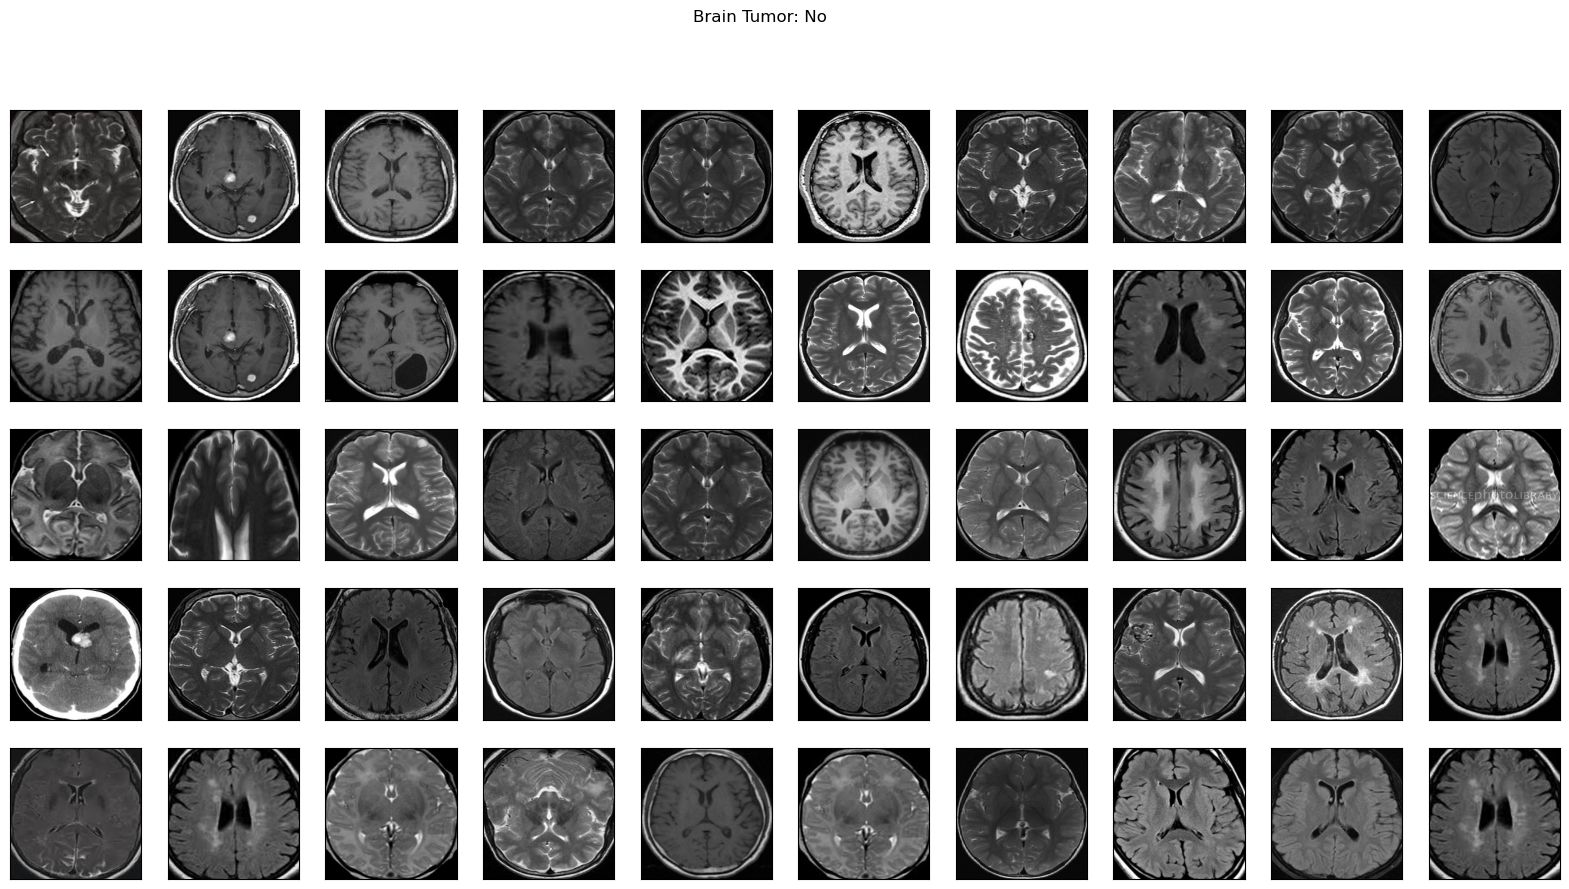

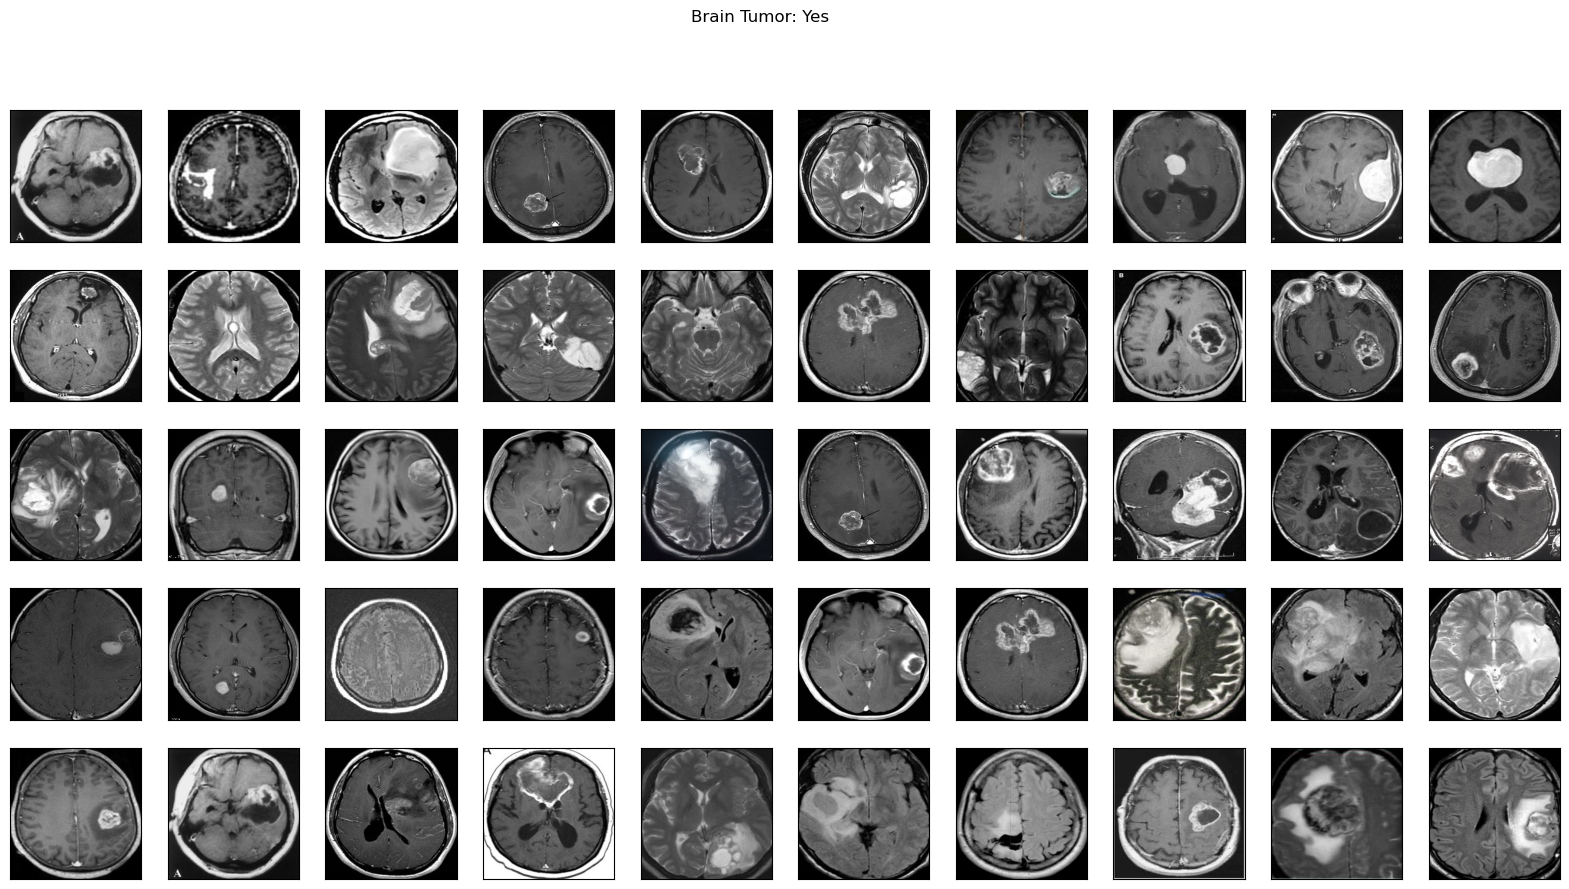

In [7]:
# Plotting sample images from raw data

def plot_Selected_Images(X, y, n=50):

    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_Images = images[:n]

        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))

        i = 1 # current plot        
        for image in n_Images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])

            # remove ticks
            plt.tick_params(axis='both', which='both',
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)

            i += 1

        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle("Brain Tumor: {}".format(label_to_str(label)))
        plt.show()

plot_Selected_Images(X, y)

# Data Splitting

In [8]:
def split_Dataset(X, y, test_size):

    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    return X_train, y_train, X_val, y_val, X_test, y_test

In [9]:
X_train, y_train, X_val, y_val, X_test, y_test = split_Dataset(X, y, test_size=0.4)

In [10]:
print ("Number of training data examples = " + str(X_train.shape[0]))
print ("Number of validation data examples = " + str(X_val.shape[0]))
print ("number of test data examples = " + str(X_test.shape[0]))
print ("X_training shape: " + str(X_train.shape))
print ("Y_training shape: " + str(y_train.shape))
print ("X_validation shape: " + str(X_val.shape))
print ("Y_validation shape: " + str(y_val.shape))
print ("X_testing shape: " + str(X_test.shape))
print ("Y_testing shape: " + str(y_test.shape))

Number of training data examples = 151
Number of validation data examples = 51
number of test data examples = 51
X_training shape: (151, 224, 224, 3)
Y_training shape: (151, 1)
X_validation shape: (51, 224, 224, 3)
Y_validation shape: (51, 1)
X_testing shape: (51, 224, 224, 3)
Y_testing shape: (51, 1)


In [11]:
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
y = dict()
y[0] = []
y[1] = []
for set_name in (y_train, y_val, y_test):
    y[0].append(np.sum(set_name == 0))
    y[1].append(np.sum(set_name == 1))

trace0 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[0],
    name='No',
    marker=dict(color='#33cc33'),
    opacity=0.6
)
trace1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[1],
    name='Yes',
    marker=dict(color='#ff3300'),
    opacity=0.6
)
data = [trace0, trace1]
layout = go.Layout(
    title='Count of classes in each dataset',
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'},
    width=800, 
    height=500 
)
fig = go.Figure(data, layout)
iplot(fig)

# CNN Model Architecture

In [25]:
def build_cnn_model(input_shape):
  
    X_input = Input(input_shape)
    X = Conv2D(64, (3, 3), strides = (1, 1), name = 'Convolutional0')(X_input)
    X = BatchNormalization(axis = 3, name = 'BatchNor0')(X)
    X = Activation('relu')(X) 

    X = MaxPooling2D((2, 2), name='MaxPooling0')(X) 
    X = Conv2D(128, (5, 5), strides=(2, 2), name='Convolutional1')(X)
    X = BatchNormalization(axis=3, name='BatchNor1')(X)
    X = Activation('relu')(X)  
  
    X = MaxPooling2D((4, 4), name='MaxPooling1')(X) 
    X = Flatten()(X)
    X = Dense(128, activation='relu')(X)
    
    X = Dense(1, activation='sigmoid', name='Output')(X) 

    model = Model(inputs = X_input, outputs = X, name='BrainTumorDetectionModel')
    return model

In [26]:
IMG_SHAPE = (img_Width, img_Height, 3)
model = build_cnn_model(IMG_SHAPE)
model.summary()

Model: "BrainTumorDetectionModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 Convolutional0 (Conv2D)     (None, 222, 222, 64)      1792      
                                                                 
 BatchNor0 (BatchNormalizat  (None, 222, 222, 64)      256       
 ion)                                                            
                                                                 
 activation_2 (Activation)   (None, 222, 222, 64)      0         
                                                                 
 MaxPooling0 (MaxPooling2D)  (None, 111, 111, 64)      0         
                                                                 
 Convolutional1 (Conv2D)     (None, 54, 54, 128)       204928    
                                          

In [27]:
# Method for elapsing time during training model
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{}:{}".format(h,m,round(s,1))

In [28]:
# Model compilation
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) 
start_time = time.time()

# model fitting
model.fit(x=X_train, y=y_train, batch_size=32, epochs=30, validation_data=(X_val, y_val))
end_time = time.time()
execution_time = (end_time - start_time)
print("Elapsed time: {}".format(hms_string(execution_time)))


Epoch 1/30
5/5 [==============================] - 10s 2s/step - loss: 11.5390 - accuracy: 0.5364 - val_loss: 1.1011 - val_accuracy: 0.3333
Epoch 2/30
5/5 [==============================] - 7s 1s/step - loss: 3.2403 - accuracy: 0.5828 - val_loss: 1.4111 - val_accuracy: 0.6667
Epoch 3/30
5/5 [==============================] - 7s 1s/step - loss: 2.3662 - accuracy: 0.6026 - val_loss: 0.5775 - val_accuracy: 0.6863
Epoch 4/30
5/5 [==============================] - 7s 1s/step - loss: 1.5235 - accuracy: 0.5894 - val_loss: 0.7498 - val_accuracy: 0.6667
Epoch 5/30
5/5 [==============================] - 7s 1s/step - loss: 0.9664 - accuracy: 0.6623 - val_loss: 1.0994 - val_accuracy: 0.3725
Epoch 6/30
5/5 [==============================] - 7s 1s/step - loss: 0.9149 - accuracy: 0.6623 - val_loss: 0.5958 - val_accuracy: 0.6078
Epoch 7/30
5/5 [==============================] - 7s 1s/step - loss: 0.5811 - accuracy: 0.7483 - val_loss: 0.6407 - val_accuracy: 0.6078
Epoch 8/30
5/5 [=======================

In [29]:
history = model.history.history

In [30]:
# Method to plot loss and accuracy curves

def plot_loss_and_accuracy(history):
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']

    # Creates a sequence that represents the number of epochs
    epochs = range(1, len(train_loss) + 1)

    # Plotting the training and validation loss
    plt.figure(figsize=(7, 4))
    plt.plot(epochs, train_loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'orange', label='Validation Loss')

    # Plotting the training and validation accuracy
    plt.plot(epochs, train_acc, 'g', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')

    # Adding title and labels
    plt.title('Loss and Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Loss/Accuracy')
    plt.legend()

    # Show plot
    plt.show()




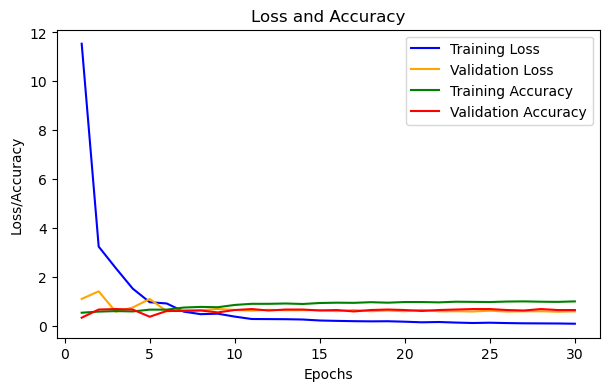

In [31]:
plot_loss_and_accuracy(history)

In [32]:
# Method to plot confusion matrix

def plot_Confusion_Matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.figure(figsize = (4,4))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

5/5 [==============================] - 4s 344ms/step
Training Accuracy = 0.89


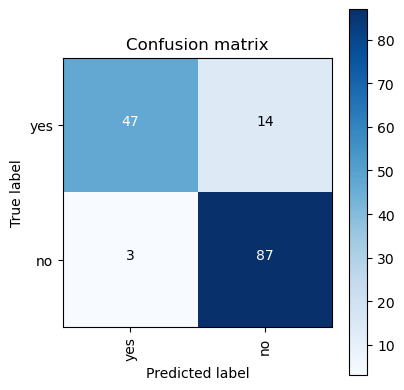

In [37]:
labels = ['yes','no']
# Prediction on traning set
predictions = model.predict(X_train)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_train, predictions)
print('Training Accuracy = %.2f' % accuracy)
confusion_Matrix = confusion_matrix(y_train, predictions) 
cm = plot_Confusion_Matrix(confusion_Matrix, classes = labels, normalize=False)

2/2 [==============================] - 1s 224ms/step
Validation Accuracy = 0.65


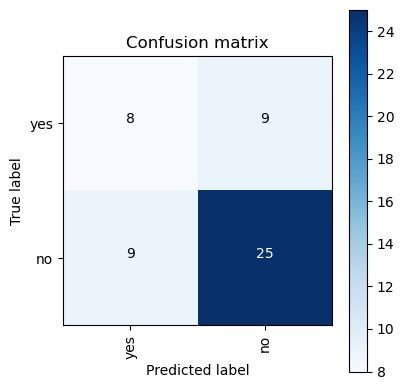

In [33]:

# Prediction on validation set
labels = ['yes','no']
predictions = model.predict(X_val)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Validation Accuracy = %.2f' % accuracy)

confusion_Matrix = confusion_matrix(y_val, predictions) 
cm = plot_Confusion_Matrix(confusion_Matrix, classes = labels, normalize=False)

2/2 [==============================] - 1s 223ms/step
Test Accuracy = 0.71


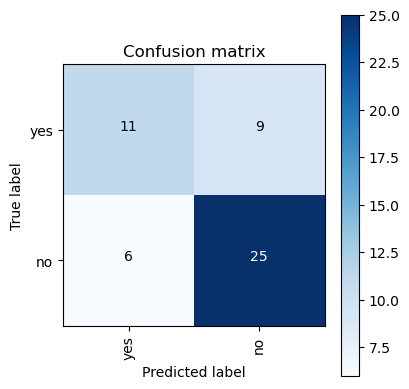

In [34]:
# Prediction on test set
predictions = model.predict(X_test)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

confusion_Matrix = confusion_matrix(y_test, predictions) 
cm = plot_Confusion_Matrix(confusion_Matrix, classes = labels, normalize=False)

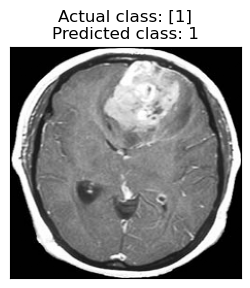

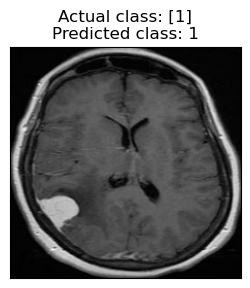

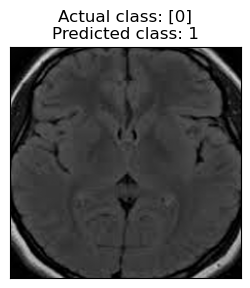

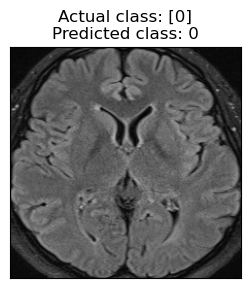

In [35]:
for i in range(4):
    plt.figure(figsize=(3,3))
    plt.imshow(X_test[i])
    plt.xticks([])
    plt.yticks([])
    plt.title(f'Actual class: {y_test[i]}\nPredicted class: {predictions[i]}')
    plt.show()

In [36]:
# Classification Report of CNN Model with Raw Data
report1 = classification_report(y_test, predictions)
print(report1)

              precision    recall  f1-score   support

           0       0.65      0.55      0.59        20
           1       0.74      0.81      0.77        31

    accuracy                           0.71        51
   macro avg       0.69      0.68      0.68        51
weighted avg       0.70      0.71      0.70        51



The performance of the CNN model is very not good. As the trainig and testing score both are very poor, so data augmentation can be applied to slove this problem.

# Data Augmentation

In [16]:
def augment_data(file_dir, n_generated_samples, save_to_dir):

    data_gen = ImageDataGenerator(rotation_range=10, 
                                  width_shift_range=0.1, 
                                  height_shift_range=0.1, 
                                  shear_range=0.1, 
                                  brightness_range=(0.3, 1.0),
                                  horizontal_flip=True, 
                                  vertical_flip=True, 
                                  fill_mode='nearest'
                                 )

    
    for filename in listdir(file_dir):
        # load the image
        image = cv2.imread(file_dir + '\\' + filename)
        # reshape the image
        image = image.reshape((1,)+image.shape)
        # prefix of the names for the generated sampels.
        save_prefix = 'aug_' + filename[:-4]
        # generate 'n_generated_samples' sample images
        i=0
        for batch in data_gen.flow(x=image, batch_size=1, save_to_dir=save_to_dir, 
                                           save_prefix=save_prefix, save_format='jpg'):
            i += 1
            if i > n_generated_samples:
                break

In [17]:
augmented_image_dir = 'augmented_dataset/'
# augment data for the examples with label equal to 'yes' representing tumurous examples
augment_data(file_dir='yes/', n_generated_samples=6, save_to_dir=augmented_image_dir+'yes')
# augment data for the examples with label equal to 'no' representing non-tumurous examples
augment_data(file_dir='no/', n_generated_samples=9, save_to_dir=augmented_image_dir+'no')


In [18]:
def data_summary(main_path):
    
    yes_path = main_path+'yes'
    no_path = main_path+'no'
        
    # number of files (images) that are in the the folder named 'yes' that represent tumorous (positive) examples
    m_pos = len(listdir(yes_path))
    # number of files (images) that are in the the folder named 'no' that represent non-tumorous (negative) examples
    m_neg = len(listdir(no_path))
    # number of all examples
    m = (m_pos+m_neg)
    
    pos_prec = (m_pos* 100.0)/ m
    neg_prec = (m_neg* 100.0)/ m
    
    print(f"Number of examples: {m}")
    print(f"Percentage of positive examples: {pos_prec}%, number of pos examples: {m_pos}") 
    print(f"Percentage of negative examples: {neg_prec}%, number of neg examples: {m_neg}") 

In [19]:
data_summary(augmented_image_dir)

Number of examples: 2063
Percentage of positive examples: 52.59331071255453%, number of pos examples: 1085
Percentage of negative examples: 47.40668928744547%, number of neg examples: 978


# Data Loading from Augmented Dataset

In [20]:
augmented_path = 'augmented_dataset/'
# augmented data (yes and no) contains both the original and the new generated examples
augmented_yes = augmented_path + 'yes'
augmented_no = augmented_path + 'no'
img_Width, img_Height = (224, 224)
X, y = load_data([augmented_yes, augmented_no], (img_Width, img_Height))

aug_Y100_0_1767.jpg
augmented_dataset/yes
aug_Y100_0_4825.jpg
augmented_dataset/yes
aug_Y100_0_5339.jpg
augmented_dataset/yes
aug_Y100_0_5831.jpg
augmented_dataset/yes
aug_Y100_0_6144.jpg
augmented_dataset/yes
aug_Y100_0_8212.jpg
augmented_dataset/yes
aug_Y100_0_9645.jpg
augmented_dataset/yes
aug_Y101_0_2334.jpg
augmented_dataset/yes
aug_Y101_0_2877.jpg
augmented_dataset/yes
aug_Y101_0_505.jpg
augmented_dataset/yes
aug_Y101_0_5644.jpg
augmented_dataset/yes
aug_Y101_0_7394.jpg
augmented_dataset/yes
aug_Y101_0_7866.jpg
augmented_dataset/yes
aug_Y101_0_8795.jpg
augmented_dataset/yes
aug_Y102_0_2611.jpg
augmented_dataset/yes
aug_Y102_0_6299.jpg
augmented_dataset/yes
aug_Y102_0_7022.jpg
augmented_dataset/yes
aug_Y102_0_8159.jpg
augmented_dataset/yes
aug_Y102_0_8799.jpg
augmented_dataset/yes
aug_Y102_0_8987.jpg
augmented_dataset/yes
aug_Y102_0_9878.jpg
augmented_dataset/yes
aug_Y103_0_2408.jpg
augmented_dataset/yes
aug_Y103_0_4780.jpg
augmented_dataset/yes
aug_Y103_0_4807.jpg
augmented_datas

aug_Y156_0_9458.jpg
augmented_dataset/yes
aug_Y156_0_9579.jpg
augmented_dataset/yes
aug_Y157_0_1229.jpg
augmented_dataset/yes
aug_Y157_0_1614.jpg
augmented_dataset/yes
aug_Y157_0_4029.jpg
augmented_dataset/yes
aug_Y157_0_4207.jpg
augmented_dataset/yes
aug_Y157_0_5021.jpg
augmented_dataset/yes
aug_Y157_0_6695.jpg
augmented_dataset/yes
aug_Y157_0_8229.jpg
augmented_dataset/yes
aug_Y158_0_2324.jpg
augmented_dataset/yes
aug_Y158_0_3500.jpg
augmented_dataset/yes
aug_Y158_0_4870.jpg
augmented_dataset/yes
aug_Y158_0_6757.jpg
augmented_dataset/yes
aug_Y158_0_7078.jpg
augmented_dataset/yes
aug_Y158_0_7747.jpg
augmented_dataset/yes
aug_Y158_0_9172.jpg
augmented_dataset/yes
aug_Y159_0_179.jpg
augmented_dataset/yes
aug_Y159_0_1873.jpg
augmented_dataset/yes
aug_Y159_0_3392.jpg
augmented_dataset/yes
aug_Y159_0_78.jpg
augmented_dataset/yes
aug_Y159_0_8129.jpg
augmented_dataset/yes
aug_Y159_0_9169.jpg
augmented_dataset/yes
aug_Y159_0_9518.jpg
augmented_dataset/yes
aug_Y15_0_232.jpg
augmented_dataset/y

aug_Y195_0_2319.jpg
augmented_dataset/yes
aug_Y195_0_5307.jpg
augmented_dataset/yes
aug_Y195_0_6082.jpg
augmented_dataset/yes
aug_Y195_0_7414.jpg
augmented_dataset/yes
aug_Y195_0_8755.jpg
augmented_dataset/yes
aug_Y195_0_9643.jpg
augmented_dataset/yes
aug_Y195_0_9798.jpg
augmented_dataset/yes
aug_Y19_0_1262.jpg
augmented_dataset/yes
aug_Y19_0_1867.jpg
augmented_dataset/yes
aug_Y19_0_2988.jpg
augmented_dataset/yes
aug_Y19_0_5729.jpg
augmented_dataset/yes
aug_Y19_0_6061.jpg
augmented_dataset/yes
aug_Y19_0_6695.jpg
augmented_dataset/yes
aug_Y19_0_8438.jpg
augmented_dataset/yes
aug_Y1_0_1511.jpg
augmented_dataset/yes
aug_Y1_0_2342.jpg
augmented_dataset/yes
aug_Y1_0_577.jpg
augmented_dataset/yes
aug_Y1_0_7328.jpg
augmented_dataset/yes
aug_Y1_0_7737.jpg
augmented_dataset/yes
aug_Y1_0_8345.jpg
augmented_dataset/yes
aug_Y1_0_8586.jpg
augmented_dataset/yes
aug_Y20_0_2575.jpg
augmented_dataset/yes
aug_Y20_0_3595.jpg
augmented_dataset/yes
aug_Y20_0_3606.jpg
augmented_dataset/yes
aug_Y20_0_4429.jp

aug_Y28_0_8870.jpg
augmented_dataset/yes
aug_Y28_0_8949.jpg
augmented_dataset/yes
aug_Y29_0_188.jpg
augmented_dataset/yes
aug_Y29_0_2659.jpg
augmented_dataset/yes
aug_Y29_0_2754.jpg
augmented_dataset/yes
aug_Y29_0_2807.jpg
augmented_dataset/yes
aug_Y29_0_6176.jpg
augmented_dataset/yes
aug_Y29_0_6804.jpg
augmented_dataset/yes
aug_Y29_0_8110.jpg
augmented_dataset/yes
aug_Y2_0_1584.jpg
augmented_dataset/yes
aug_Y2_0_2015.jpg
augmented_dataset/yes
aug_Y2_0_3567.jpg
augmented_dataset/yes
aug_Y2_0_3597.jpg
augmented_dataset/yes
aug_Y2_0_5738.jpg
augmented_dataset/yes
aug_Y2_0_6219.jpg
augmented_dataset/yes
aug_Y2_0_9976.jpg
augmented_dataset/yes
aug_Y30_0_223.jpg
augmented_dataset/yes
aug_Y30_0_2271.jpg
augmented_dataset/yes
aug_Y30_0_3640.jpg
augmented_dataset/yes
aug_Y30_0_4592.jpg
augmented_dataset/yes
aug_Y30_0_5720.jpg
augmented_dataset/yes
aug_Y30_0_6626.jpg
augmented_dataset/yes
aug_Y30_0_9527.jpg
augmented_dataset/yes
aug_Y31_0_1391.jpg
augmented_dataset/yes
aug_Y31_0_2043.jpg
augmen

aug_Y56_0_8836.jpg
augmented_dataset/yes
aug_Y58_0_2257.jpg
augmented_dataset/yes
aug_Y58_0_4611.jpg
augmented_dataset/yes
aug_Y58_0_5026.jpg
augmented_dataset/yes
aug_Y58_0_6532.jpg
augmented_dataset/yes
aug_Y58_0_8491.jpg
augmented_dataset/yes
aug_Y58_0_9034.jpg
augmented_dataset/yes
aug_Y58_0_9067.jpg
augmented_dataset/yes
aug_Y59_0_292.jpg
augmented_dataset/yes
aug_Y59_0_4180.jpg
augmented_dataset/yes
aug_Y59_0_5240.jpg
augmented_dataset/yes
aug_Y59_0_5924.jpg
augmented_dataset/yes
aug_Y59_0_6063.jpg
augmented_dataset/yes
aug_Y59_0_6672.jpg
augmented_dataset/yes
aug_Y59_0_7053.jpg
augmented_dataset/yes
aug_Y60_0_1099.jpg
augmented_dataset/yes
aug_Y60_0_2731.jpg
augmented_dataset/yes
aug_Y60_0_3713.jpg
augmented_dataset/yes
aug_Y60_0_6094.jpg
augmented_dataset/yes
aug_Y60_0_6427.jpg
augmented_dataset/yes
aug_Y60_0_8074.jpg
augmented_dataset/yes
aug_Y60_0_8756.jpg
augmented_dataset/yes
aug_Y61_0_1909.jpg
augmented_dataset/yes
aug_Y61_0_3091.jpg
augmented_dataset/yes
aug_Y61_0_4242.jp

aug_Y92_0_9079.jpg
augmented_dataset/yes
aug_Y95_0_1233.jpg
augmented_dataset/yes
aug_Y95_0_1297.jpg
augmented_dataset/yes
aug_Y95_0_1494.jpg
augmented_dataset/yes
aug_Y95_0_1617.jpg
augmented_dataset/yes
aug_Y95_0_1809.jpg
augmented_dataset/yes
aug_Y95_0_361.jpg
augmented_dataset/yes
aug_Y95_0_3653.jpg
augmented_dataset/yes
aug_Y96_0_2905.jpg
augmented_dataset/yes
aug_Y96_0_4246.jpg
augmented_dataset/yes
aug_Y96_0_4305.jpg
augmented_dataset/yes
aug_Y96_0_5618.jpg
augmented_dataset/yes
aug_Y96_0_6080.jpg
augmented_dataset/yes
aug_Y96_0_8528.jpg
augmented_dataset/yes
aug_Y96_0_9366.jpg
augmented_dataset/yes
aug_Y97_0_1109.jpg
augmented_dataset/yes
aug_Y97_0_165.jpg
augmented_dataset/yes
aug_Y97_0_3474.jpg
augmented_dataset/yes
aug_Y97_0_4928.jpg
augmented_dataset/yes
aug_Y97_0_7245.jpg
augmented_dataset/yes
aug_Y97_0_783.jpg
augmented_dataset/yes
aug_Y97_0_8551.jpg
augmented_dataset/yes
aug_Y98_0_2307.jpg
augmented_dataset/yes
aug_Y98_0_4223.jpg
augmented_dataset/yes
aug_Y98_0_44.jpg
au

aug_25 no_0_5735.jpg
augmented_dataset/no
aug_25 no_0_7850.jpg
augmented_dataset/no
aug_25 no_0_9537.jpg
augmented_dataset/no
aug_26 no_0_1405.jpg
augmented_dataset/no
aug_26 no_0_1527.jpg
augmented_dataset/no
aug_26 no_0_1701.jpg
augmented_dataset/no
aug_26 no_0_2249.jpg
augmented_dataset/no
aug_26 no_0_3320.jpg
augmented_dataset/no
aug_26 no_0_3426.jpg
augmented_dataset/no
aug_26 no_0_5035.jpg
augmented_dataset/no
aug_26 no_0_7917.jpg
augmented_dataset/no
aug_26 no_0_8043.jpg
augmented_dataset/no
aug_26 no_0_8085.jpg
augmented_dataset/no
aug_27 no_0_1378.jpg
augmented_dataset/no
aug_27 no_0_225.jpg
augmented_dataset/no
aug_27 no_0_2488.jpg
augmented_dataset/no
aug_27 no_0_3069.jpg
augmented_dataset/no
aug_27 no_0_3253.jpg
augmented_dataset/no
aug_27 no_0_4156.jpg
augmented_dataset/no
aug_27 no_0_5569.jpg
augmented_dataset/no
aug_27 no_0_636.jpg
augmented_dataset/no
aug_27 no_0_761.jpg
augmented_dataset/no
aug_27 no_0_9734.jpg
augmented_dataset/no
aug_28 no_0_2482.jpg
augmented_datase

aug_43 no_0_9224.jpg
augmented_dataset/no
aug_43 no_0_9465.jpg
augmented_dataset/no
aug_43 no_0_9720.jpg
augmented_dataset/no
aug_44no_0_1967.jpg
augmented_dataset/no
aug_44no_0_3104.jpg
augmented_dataset/no
aug_44no_0_3832.jpg
augmented_dataset/no
aug_44no_0_3854.jpg
augmented_dataset/no
aug_44no_0_4141.jpg
augmented_dataset/no
aug_44no_0_5172.jpg
augmented_dataset/no
aug_44no_0_6028.jpg
augmented_dataset/no
aug_44no_0_8541.jpg
augmented_dataset/no
aug_44no_0_9667.jpg
augmented_dataset/no
aug_44no_0_9905.jpg
augmented_dataset/no
aug_45 no_0_1289.jpg
augmented_dataset/no
aug_45 no_0_3851.jpg
augmented_dataset/no
aug_45 no_0_4358.jpg
augmented_dataset/no
aug_45 no_0_5873.jpg
augmented_dataset/no
aug_45 no_0_6512.jpg
augmented_dataset/no
aug_45 no_0_7782.jpg
augmented_dataset/no
aug_45 no_0_8227.jpg
augmented_dataset/no
aug_45 no_0_8513.jpg
augmented_dataset/no
aug_45 no_0_9088.jpg
augmented_dataset/no
aug_45 no_0_9205.jpg
augmented_dataset/no
aug_46 no_0_1122.jpg
augmented_dataset/no
au

aug_N22_0_1914.jpg
augmented_dataset/no
aug_N22_0_1995.jpg
augmented_dataset/no
aug_N22_0_2847.jpg
augmented_dataset/no
aug_N22_0_3456.jpg
augmented_dataset/no
aug_N22_0_4059.jpg
augmented_dataset/no
aug_N22_0_6832.jpg
augmented_dataset/no
aug_N22_0_7523.jpg
augmented_dataset/no
aug_N22_0_8457.jpg
augmented_dataset/no
aug_N22_0_9695.jpg
augmented_dataset/no
aug_N22_0_9846.jpg
augmented_dataset/no
aug_N26_0_1253.jpg
augmented_dataset/no
aug_N26_0_1644.jpg
augmented_dataset/no
aug_N26_0_2624.jpg
augmented_dataset/no
aug_N26_0_4239.jpg
augmented_dataset/no
aug_N26_0_4290.jpg
augmented_dataset/no
aug_N26_0_5494.jpg
augmented_dataset/no
aug_N26_0_7388.jpg
augmented_dataset/no
aug_N26_0_7575.jpg
augmented_dataset/no
aug_N26_0_8412.jpg
augmented_dataset/no
aug_N26_0_8646.jpg
augmented_dataset/no
aug_N2_0_1026.jpg
augmented_dataset/no
aug_N2_0_113.jpg
augmented_dataset/no
aug_N2_0_1319.jpg
augmented_dataset/no
aug_N2_0_4450.jpg
augmented_dataset/no
aug_N2_0_603.jpg
augmented_dataset/no
aug_N2_

aug_no 92_0_4752.jpg
augmented_dataset/no
aug_no 92_0_5930.jpg
augmented_dataset/no
aug_no 92_0_6130.jpg
augmented_dataset/no
aug_no 92_0_6708.jpg
augmented_dataset/no
aug_no 92_0_7469.jpg
augmented_dataset/no
aug_no 92_0_9088.jpg
augmented_dataset/no
aug_no 92_0_9730.jpg
augmented_dataset/no
aug_no 94_0_1932.jpg
augmented_dataset/no
aug_no 94_0_3452.jpg
augmented_dataset/no
aug_no 94_0_3924.jpg
augmented_dataset/no
aug_no 94_0_4576.jpg
augmented_dataset/no
aug_no 94_0_463.jpg
augmented_dataset/no
aug_no 94_0_4717.jpg
augmented_dataset/no
aug_no 94_0_5011.jpg
augmented_dataset/no
aug_no 94_0_5274.jpg
augmented_dataset/no
aug_no 94_0_6.jpg
augmented_dataset/no
aug_no 94_0_9005.jpg
augmented_dataset/no
aug_no 95_0_1752.jpg
augmented_dataset/no
aug_no 95_0_1945.jpg
augmented_dataset/no
aug_no 95_0_2231.jpg
augmented_dataset/no
aug_no 95_0_4943.jpg
augmented_dataset/no
aug_no 95_0_5069.jpg
augmented_dataset/no
aug_no 95_0_5996.jpg
augmented_dataset/no
aug_no 95_0_8250.jpg
augmented_dataset

Number of examples is:2063


# Augmented Data Splitting 

In [21]:
def split_data(X, y, test_size):

    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    return X_train, y_train, X_val, y_val, X_test, y_test

In [22]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.4)

In [23]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 1237
number of development examples = 413
number of test examples = 413
X_train shape: (1237, 224, 224, 3)
Y_train shape: (1237, 1)
X_val (dev) shape: (413, 224, 224, 3)
Y_val (dev) shape: (413, 1)
X_test shape: (413, 224, 224, 3)
Y_test shape: (413, 1)


In [24]:
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go

y = dict()
y[0] = []
y[1] = []
for set_name in (y_train, y_val, y_test):
    y[0].append(np.sum(set_name == 0))
    y[1].append(np.sum(set_name == 1))

trace0 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[0],
    name='No',
    marker=dict(color='#33cc33'),
    opacity=0.7
)
trace1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[1],
    name='Yes',
    marker=dict(color='#ff3300'),
    opacity=0.7
)
data = [trace0, trace1]
layout = go.Layout(
    title='Count of classes in each set',
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'},
    width=800,  # Set the width of the figure
    height=500
)
fig = go.Figure(data, layout)
iplot(fig)

In [29]:
IMG_SHAPE = (img_Width, img_Height, 3)
model = build_cnn_model(IMG_SHAPE)
model.summary()

Model: "BrainTumorDetectionModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 Convolutional0 (Conv2D)     (None, 222, 222, 64)      1792      
                                                                 
 BatchNor0 (BatchNormalizat  (None, 222, 222, 64)      256       
 ion)                                                            
                                                                 
 activation_2 (Activation)   (None, 222, 222, 64)      0         
                                                                 
 MaxPooling0 (MaxPooling2D)  (None, 111, 111, 64)      0         
                                                                 
 Convolutional1 (Conv2D)     (None, 54, 54, 128)       204928    
                                          

In [30]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) 
start_time = time.time()
model.fit(x=X_train, y=y_train, batch_size=32, epochs=30, validation_data=(X_val, y_val))
end_time = time.time()
execution_time = (end_time - start_time)
print("Elapsed time: {}".format(hms_string(execution_time)))


Epoch 1/30
39/39 [==============================] - 69s 2s/step - loss: 3.5657 - accuracy: 0.5964 - val_loss: 0.6402 - val_accuracy: 0.6586
Epoch 2/30
39/39 [==============================] - 60s 2s/step - loss: 1.0096 - accuracy: 0.6812 - val_loss: 0.5843 - val_accuracy: 0.6901
Epoch 3/30
39/39 [==============================] - 59s 2s/step - loss: 0.7989 - accuracy: 0.7240 - val_loss: 0.7241 - val_accuracy: 0.6320
Epoch 4/30
39/39 [==============================] - 65s 2s/step - loss: 0.5154 - accuracy: 0.7869 - val_loss: 0.7281 - val_accuracy: 0.6077
Epoch 5/30
39/39 [==============================] - 60s 2s/step - loss: 0.7133 - accuracy: 0.7530 - val_loss: 0.5808 - val_accuracy: 0.7119
Epoch 6/30
39/39 [==============================] - 61s 2s/step - loss: 0.3863 - accuracy: 0.8458 - val_loss: 0.7302 - val_accuracy: 0.6271
Epoch 7/30
39/39 [==============================] - 58s 1s/step - loss: 0.3295 - accuracy: 0.8765 - val_loss: 0.5423 - val_accuracy: 0.6998
Epoch 8/30
39/39 [==

In [31]:
history = model.history.history

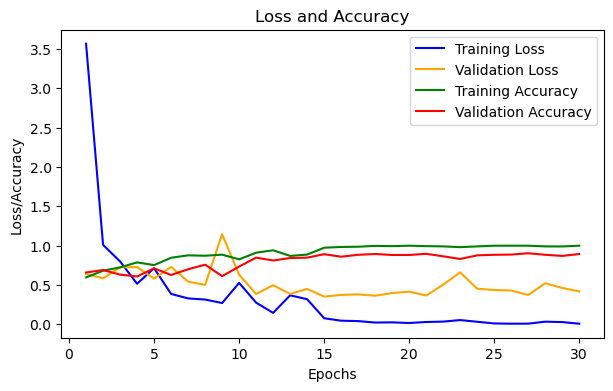

In [32]:
plot_loss_and_accuracy(history)

39/39 [==============================] - 15s 368ms/step
Training Accuracy = 1.00


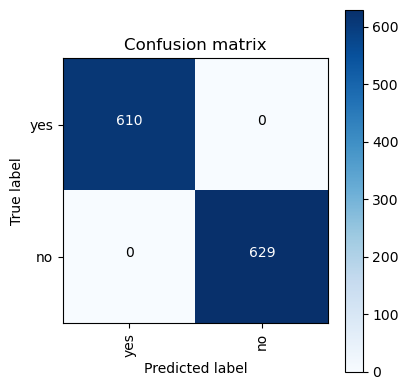

In [33]:
labels = ['yes','no']
# Prediction on traning set
predictions = model.predict(X_train)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_train, predictions)
print('Training Accuracy = %.2f' % accuracy)
confusion_Matrix = confusion_matrix(y_train, predictions) 
cm = plot_Confusion_Matrix(confusion_Matrix, classes = labels, normalize=False)

13/13 [==============================] - 5s 358ms/step
Validation Accuracy = 0.89


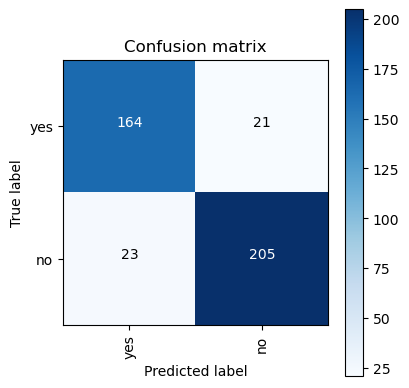

In [34]:
labels = ['yes','no']
# Prediction on val set
predictions = model.predict(X_val)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Validation Accuracy = %.2f' % accuracy)

confusion_Matrix = confusion_matrix(y_val, predictions) 
cm = plot_Confusion_Matrix(confusion_Matrix, classes = labels, normalize=False)

13/13 [==============================] - 4s 341ms/step
Test Accuracy = 0.93


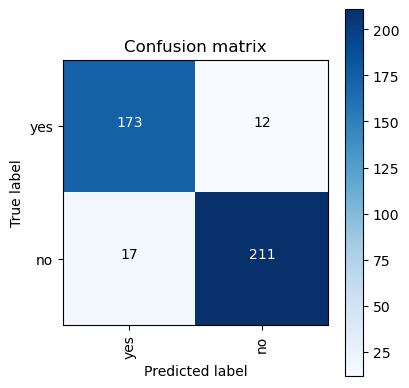

In [35]:
# Prediction on test set
predictions = model.predict(X_test)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

confusion_Matrix = confusion_matrix(y_test, predictions) 
cm = plot_Confusion_Matrix(confusion_Matrix, classes = labels, normalize=False)

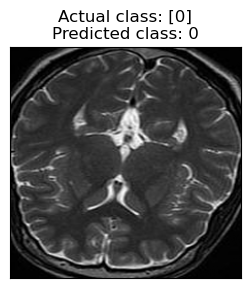

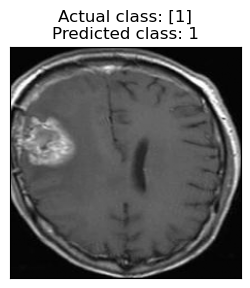

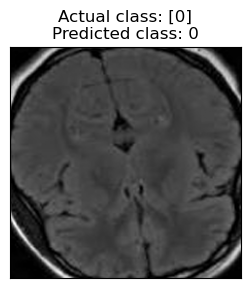

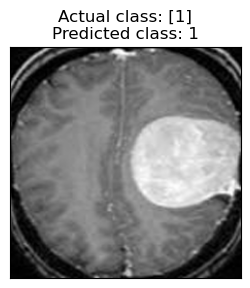

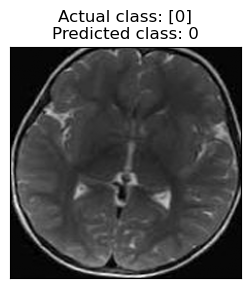

In [36]:
for i in range(5):
    plt.figure(figsize=(3,3))
    plt.imshow(X_test[i])
    plt.xticks([])
    plt.yticks([])
    plt.title(f'Actual class: {y_test[i]}\nPredicted class: {predictions[i]}')
    plt.show()

In [37]:
# Classification Report of CNN Model with Augmented Data
report2 = classification_report(y_test, predictions)
print(report2)

              precision    recall  f1-score   support

           0       0.91      0.94      0.92       185
           1       0.95      0.93      0.94       228

    accuracy                           0.93       413
   macro avg       0.93      0.93      0.93       413
weighted avg       0.93      0.93      0.93       413



# Comparison Between Raw data and Augmented Data

In [82]:

def extract_metrics(report):
    # Parse the classification report into a dictionary
    report_data = {}
    lines = report.split('\n')
    
    for line in lines:
        row = line.split()
        if len(row) == 0:
            continue  # Skip empty lines
        if len(row) == 5:
            class_name, precision, recall, f1_score, support = row
            report_data[class_name] = {
                'precision': float(precision),
                'recall': float(recall),
                'f1_score': float(f1_score),
                'support': int(support)
            }
        elif len(row) == 6 and row[0].isdigit():  # Check if it matches the expected format
            # Sometimes classification report adds a space which creates an extra column
            class_name = row[0]
            precision = row[1]
            recall = row[2]
            f1_score = row[3]
            support = row[4]
            report_data[class_name] = {
                'precision': float(precision),
                'recall': float(recall),
                'f1_score': float(f1_score),
                'support': int(support)
            }
    
    # Extracting accuracy directly from the report
    for line in lines:
        if "accuracy" in line:
            accuracy = float(line.split()[1])
            report_data['accuracy'] = accuracy
            break

    return report_data



In [83]:
# Extract metrics from the classification reports
real_data_metrics = extract_metrics(report1)
augmented_data_metrics = extract_metrics(report2)

# Prepare the data for plotting
metrics = ['accuracy', 'precision', 'recall', 'f1_score']
real_data_values = [real_data_metrics['accuracy'],
                    real_data_metrics['1']['precision'],
                    real_data_metrics['1']['recall'],
                    real_data_metrics['1']['f1_score']]

augmented_data_values = [augmented_data_metrics['accuracy'],
                         augmented_data_metrics['1']['precision'],
                         augmented_data_metrics['1']['recall'],
                         augmented_data_metrics['1']['f1_score']]


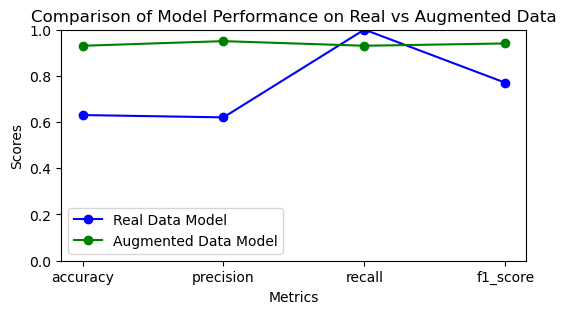

In [84]:
# Plot the metrics
x = np.arange(len(metrics))

plt.figure(figsize=(6, 3))
plt.plot(x, real_data_values, marker='o', label='Real Data Model', linestyle='-', color='blue')
plt.plot(x, augmented_data_values, marker='o', label='Augmented Data Model', linestyle='-', color='green')

plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Comparison of Model Performance on Real vs Augmented Data')
plt.xticks(x, metrics)
plt.ylim(0, 1)
plt.legend()
plt.show()


# VGG16 Model

In [39]:
IMG_SHAPE = (img_Width, img_Height, 3)
vgg_with_avgpool = VGG16(input_shape=IMG_SHAPE, weights='imagenet', include_top=False)
vgg_with_avgpool.input

<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_3')>

In [40]:
for layer in vgg_with_avgpool.layers:
  layer.trainable = False
     

In [41]:
# Costomizing last layer
x = vgg_with_avgpool.output
x = GlobalAveragePooling2D()(x) 
x = Dense(512, activation='relu')(x) 
output = Dense(1, activation='sigmoid')(x)  

model = Model(inputs=vgg_with_avgpool.input, outputs=output)
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [42]:
# Customizing last layer of the model architecture
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) 
start_time = time.time()
model.fit(x=X_train, y=y_train, batch_size=32, epochs=30, validation_data=(X_val, y_val))
end_time = time.time()
execution_time = (end_time - start_time)
print("Elapsed time: {}".format(hms_string(execution_time)))


Epoch 1/30
39/39 [==============================] - 247s 6s/step - loss: 0.6177 - accuracy: 0.6408 - val_loss: 0.5744 - val_accuracy: 0.6804
Epoch 2/30
39/39 [==============================] - 239s 6s/step - loss: 0.4979 - accuracy: 0.7651 - val_loss: 0.4789 - val_accuracy: 0.7676
Epoch 3/30
39/39 [==============================] - 240s 6s/step - loss: 0.4264 - accuracy: 0.8257 - val_loss: 0.4076 - val_accuracy: 0.8305
Epoch 4/30
39/39 [==============================] - 239s 6s/step - loss: 0.3774 - accuracy: 0.8555 - val_loss: 0.3719 - val_accuracy: 0.8402
Epoch 5/30
39/39 [==============================] - 241s 6s/step - loss: 0.3523 - accuracy: 0.8531 - val_loss: 0.3608 - val_accuracy: 0.8184
Epoch 6/30
39/39 [==============================] - 239s 6s/step - loss: 0.3097 - accuracy: 0.8749 - val_loss: 0.3472 - val_accuracy: 0.8426
Epoch 7/30
39/39 [==============================] - 239s 6s/step - loss: 0.3029 - accuracy: 0.8757 - val_loss: 0.2863 - val_accuracy: 0.8765
Epoch 8/30
39

In [ ]:
history = model.history.history

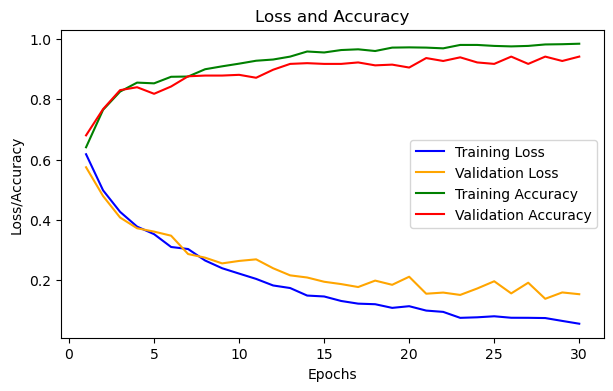

In [44]:
plot_loss_and_accuracy(history)

39/39 [==============================] - 179s 5s/step
Training Accuracy = 0.98


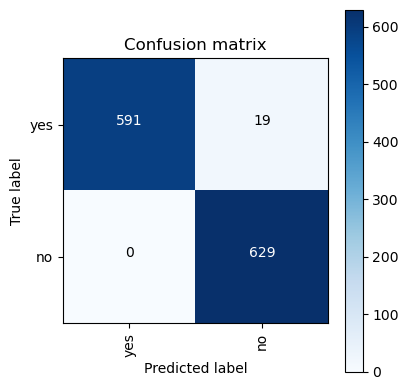

In [45]:
labels = ['yes','no']
# Prediction on traning set
predictions = model.predict(X_train)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_train, predictions)
print('Training Accuracy = %.2f' % accuracy)
confusion_Maritx = confusion_matrix(y_train, predictions) 
cm = plot_Confusion_Matrix(confusion_Maritx, classes = labels, normalize=False)

13/13 [==============================] - 59s 5s/step
Val Accuracy = 0.94


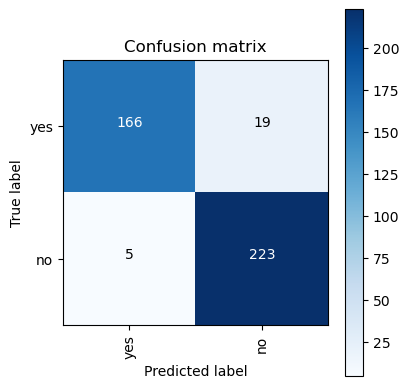

In [46]:
labels = ['yes','no']
# Prediction on val set
predictions = model.predict(X_val)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %.2f' % accuracy)

confusion_Matrix = confusion_matrix(y_val, predictions) 
cm = plot_Confusion_Matrix(confusion_Matrix, classes = labels, normalize=False)

13/13 [==============================] - 59s 5s/step
Test Accuracy = 0.95


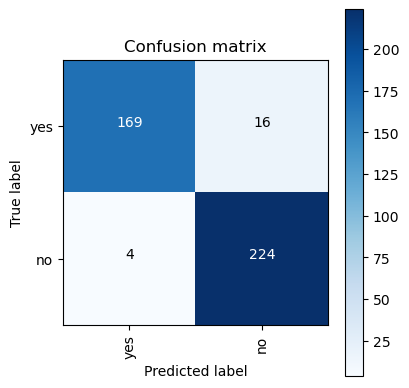

In [47]:
# test on test set
predictions = model.predict(X_test)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

confusion_Matrix = confusion_matrix(y_test, predictions) 
cm = plot_Confusion_Matrix(confusion_Matrix, classes = labels, normalize=False)


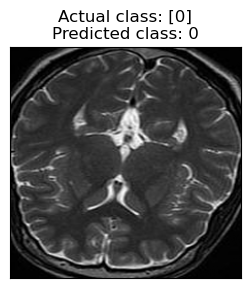

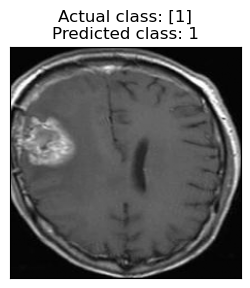

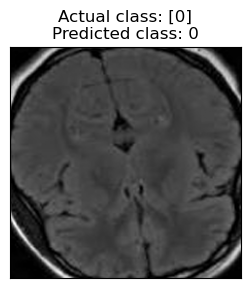

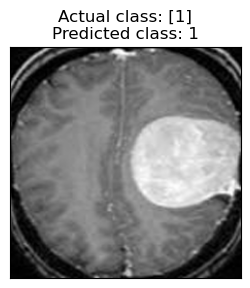

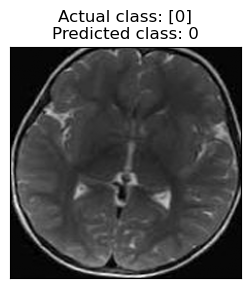

In [48]:
for i in range(5):
    plt.figure(figsize=(3,3))
    plt.imshow(X_test[i])
    plt.xticks([])
    plt.yticks([])
    plt.title(f'Actual class: {y_test[i]}\nPredicted class: {predictions[i]}')
    plt.show()

In [49]:
# Classification Report of VGG-16
report3 = classification_report(y_test, predictions)
print(report3)

              precision    recall  f1-score   support

           0       0.98      0.91      0.94       185
           1       0.93      0.98      0.96       228

    accuracy                           0.95       413
   macro avg       0.96      0.95      0.95       413
weighted avg       0.95      0.95      0.95       413



# InceptionV3

In [100]:
IMG_SHAPE = (img_Width, img_Height, 3)
inceptionV3_model = InceptionV3(input_shape=IMG_SHAPE, weights='imagenet', include_top=False)
inceptionV3_model.input

<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_7')>

In [101]:
# Freeze the layers of the base model (InceptionV3)
for layer in inceptionV3_model.layers:
    layer.trainable = False

In [102]:

x = inceptionV3_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x) 

model = Model(inputs=inceptionV3_model.input, outputs=output)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_188 (Conv2D)         (None, 111, 111, 32)         864       ['input_7[0][0]']             
                                                                                                  
 batch_normalization_188 (B  (None, 111, 111, 32)         96        ['conv2d_188[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_192 (Activation  (None, 111, 111, 32)         0         ['batch_normalization_18

                                                                                                  
 conv2d_199 (Conv2D)         (None, 25, 25, 32)           6144      ['average_pooling2d_18[0][0]']
                                                                                                  
 batch_normalization_193 (B  (None, 25, 25, 64)           192       ['conv2d_193[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_195 (B  (None, 25, 25, 64)           192       ['conv2d_195[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_198 (B  (None, 25, 25, 96)           288       ['conv2d_198[0][0]']          
 atchNorma

 )                                                                  ]']                           
                                                                                                  
 activation_209 (Activation  (None, 25, 25, 96)           0         ['batch_normalization_205[0][0
 )                                                                  ]']                           
                                                                                                  
 activation_210 (Activation  (None, 25, 25, 64)           0         ['batch_normalization_206[0][0
 )                                                                  ]']                           
                                                                                                  
 mixed1 (Concatenate)        (None, 25, 25, 288)          0         ['activation_204[0][0]',      
                                                                     'activation_206[0][0]',      
          

 )                                                                  ]']                           
                                                                                                  
 conv2d_216 (Conv2D)         (None, 25, 25, 96)           55296     ['activation_219[0][0]']      
                                                                                                  
 batch_normalization_216 (B  (None, 25, 25, 96)           288       ['conv2d_216[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_220 (Activation  (None, 25, 25, 96)           0         ['batch_normalization_216[0][0
 )                                                                  ]']                           
                                                                                                  
 conv2d_21

                                                                                                  
 conv2d_218 (Conv2D)         (None, 12, 12, 192)          147456    ['mixed3[0][0]']              
                                                                                                  
 conv2d_221 (Conv2D)         (None, 12, 12, 192)          172032    ['activation_224[0][0]']      
                                                                                                  
 conv2d_226 (Conv2D)         (None, 12, 12, 192)          172032    ['activation_229[0][0]']      
                                                                                                  
 conv2d_227 (Conv2D)         (None, 12, 12, 192)          147456    ['average_pooling2d_21[0][0]']
                                                                                                  
 batch_normalization_218 (B  (None, 12, 12, 192)          576       ['conv2d_218[0][0]']          
 atchNorma

 activation_239 (Activation  (None, 12, 12, 160)          0         ['batch_normalization_235[0][0
 )                                                                  ]']                           
                                                                                                  
 average_pooling2d_22 (Aver  (None, 12, 12, 768)          0         ['mixed4[0][0]']              
 agePooling2D)                                                                                    
                                                                                                  
 conv2d_228 (Conv2D)         (None, 12, 12, 192)          147456    ['mixed4[0][0]']              
                                                                                                  
 conv2d_231 (Conv2D)         (None, 12, 12, 192)          215040    ['activation_234[0][0]']      
                                                                                                  
 conv2d_23

 atchNormalization)                                                                               
                                                                                                  
 activation_244 (Activation  (None, 12, 12, 160)          0         ['batch_normalization_240[0][0
 )                                                                  ]']                           
                                                                                                  
 activation_249 (Activation  (None, 12, 12, 160)          0         ['batch_normalization_245[0][0
 )                                                                  ]']                           
                                                                                                  
 average_pooling2d_23 (Aver  (None, 12, 12, 768)          0         ['mixed5[0][0]']              
 agePooling2D)                                                                                    
          

                                                                                                  
 batch_normalization_250 (B  (None, 12, 12, 192)          576       ['conv2d_250[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_255 (B  (None, 12, 12, 192)          576       ['conv2d_255[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_254 (Activation  (None, 12, 12, 192)          0         ['batch_normalization_250[0][0
 )                                                                  ]']                           
                                                                                                  
 activatio

 )                                                                  ]']                           
                                                                                                  
 conv2d_259 (Conv2D)         (None, 5, 5, 320)            552960    ['activation_262[0][0]']      
                                                                                                  
 conv2d_263 (Conv2D)         (None, 5, 5, 192)            331776    ['activation_266[0][0]']      
                                                                                                  
 batch_normalization_259 (B  (None, 5, 5, 320)            960       ['conv2d_259[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_263 (B  (None, 5, 5, 192)            576       ['conv2d_263[0][0]']          
 atchNorma

 )                                                                  ]']                           
                                                                                                  
 activation_274 (Activation  (None, 5, 5, 384)            0         ['batch_normalization_270[0][0
 )                                                                  ]']                           
                                                                                                  
 activation_275 (Activation  (None, 5, 5, 384)            0         ['batch_normalization_271[0][0
 )                                                                  ]']                           
                                                                                                  
 batch_normalization_272 (B  (None, 5, 5, 192)            576       ['conv2d_272[0][0]']          
 atchNormalization)                                                                               
          

 )                                                                  ]']                           
                                                                                                  
 activation_280 (Activation  (None, 5, 5, 384)            0         ['batch_normalization_276[0][0
 )                                                                  ]']                           
                                                                                                  
 activation_283 (Activation  (None, 5, 5, 384)            0         ['batch_normalization_279[0][0
 )                                                                  ]']                           
                                                                                                  
 activation_284 (Activation  (None, 5, 5, 384)            0         ['batch_normalization_280[0][0
 )                                                                  ]']                           
          

In [103]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) 
start_time = time.time()
model.fit(x=X_train, y=y_train, batch_size=32, epochs=30, validation_data=(X_val, y_val))
end_time = time.time()
execution_time = (end_time - start_time)
print("Elapsed time: {}".format(hms_string(execution_time)))


Epoch 1/30
39/39 [==============================] - 66s 1s/step - loss: 0.5956 - accuracy: 0.7813 - val_loss: 0.2791 - val_accuracy: 0.8910
Epoch 2/30
39/39 [==============================] - 52s 1s/step - loss: 0.2326 - accuracy: 0.9048 - val_loss: 0.2071 - val_accuracy: 0.9177
Epoch 3/30
39/39 [==============================] - 52s 1s/step - loss: 0.1565 - accuracy: 0.9435 - val_loss: 0.1774 - val_accuracy: 0.9249
Epoch 4/30
39/39 [==============================] - 52s 1s/step - loss: 0.1155 - accuracy: 0.9613 - val_loss: 0.1377 - val_accuracy: 0.9419
Epoch 5/30
39/39 [==============================] - 52s 1s/step - loss: 0.0812 - accuracy: 0.9742 - val_loss: 0.1227 - val_accuracy: 0.9516
Epoch 6/30
39/39 [==============================] - 52s 1s/step - loss: 0.0681 - accuracy: 0.9806 - val_loss: 0.1115 - val_accuracy: 0.9637
Epoch 7/30
39/39 [==============================] - 52s 1s/step - loss: 0.0377 - accuracy: 0.9944 - val_loss: 0.1324 - val_accuracy: 0.9492
Epoch 8/30
39/39 [==

In [104]:
history = model.history.history

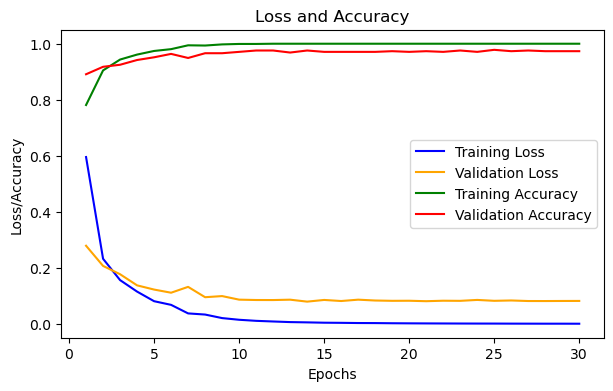

In [105]:
plot_loss_and_accuracy(history)

39/39 [==============================] - 42s 986ms/step
Training Accuracy = 1.00


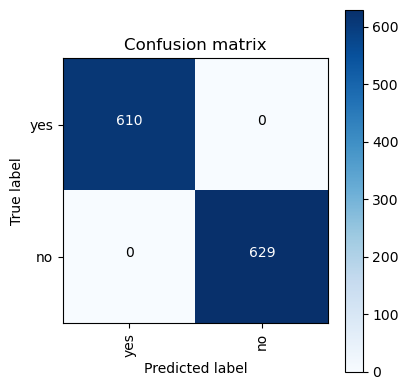

In [106]:
labels = ['yes','no']
# Prediction on traning set
predictions = model.predict(X_train)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_train, predictions)
print('Training Accuracy = %.2f' % accuracy)
confusion_mtx = confusion_matrix(y_train, predictions) 
cm = plot_Confusion_Matrix(confusion_mtx, classes = labels, normalize=False)

13/13 [==============================] - 13s 993ms/step
Val Accuracy = 0.97


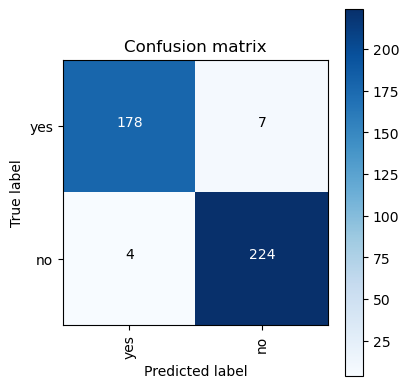

In [107]:

labels = ['yes','no']
# Prediction on val set
predictions = model.predict(X_val)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_val, predictions) 
cm = plot_Confusion_Matrix(confusion_mtx, classes = labels, normalize=False)

13/13 [==============================] - 13s 985ms/step
Test Accuracy = 0.98


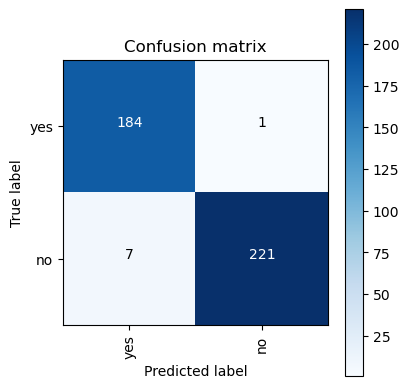

In [108]:
# test on test set
predictions = model.predict(X_test)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_test, predictions) 
cm = plot_Confusion_Matrix(confusion_mtx, classes = labels, normalize=False)


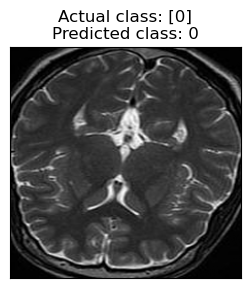

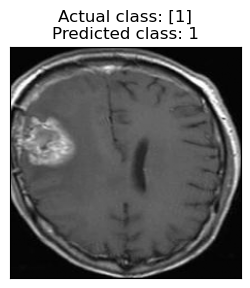

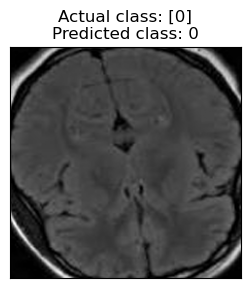

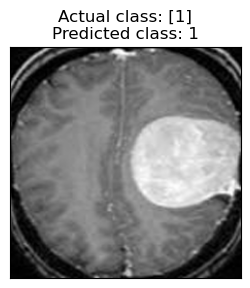

In [109]:
for i in range(4):
    plt.figure(figsize=(3,3))
    plt.imshow(X_test[i])
    plt.xticks([])
    plt.yticks([])
    plt.title(f'Actual class: {y_test[i]}\nPredicted class: {predictions[i]}')
    plt.show()

In [110]:
# Classification Report of InceptionV3 Model
report4 = classification_report(y_test, predictions)
print(report4)

              precision    recall  f1-score   support

           0       0.96      0.99      0.98       185
           1       1.00      0.97      0.98       228

    accuracy                           0.98       413
   macro avg       0.98      0.98      0.98       413
weighted avg       0.98      0.98      0.98       413



# MobileNet

In [62]:
from tensorflow.keras.applications import MobileNet


In [63]:
IMG_SHAPE = (img_Width, img_Height, 3)
mobileNet_model = MobileNet(input_shape=IMG_SHAPE, weights='imagenet', include_top=False)
mobileNet_model.input

<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_5')>

In [64]:
for layer in mobileNet_model.layers:
    layer.trainable = False

In [65]:
# Add custom layers on top of MobileNet
x = mobileNet_model.output
x = GlobalAveragePooling2D()(x) 
x = Dense(512, activation='relu')(x)  
output = Dense(1, activation='sigmoid')(x) 

model = Model(inputs=mobileNet_model.input, outputs=output)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32)      128 

 )                                                               
                                                                 
 conv_dw_8_bn (BatchNormali  (None, 14, 14, 512)       2048      
 zation)                                                         
                                                                 
 conv_dw_8_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_pw_8 (Conv2D)          (None, 14, 14, 512)       262144    
                                                                 
 conv_pw_8_bn (BatchNormali  (None, 14, 14, 512)       2048      
 zation)                                                         
                                                                 
 conv_pw_8_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_dw_9 (DepthwiseConv2D  (None, 14, 14, 512)       4608      
 )        

In [66]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) 
start_time = time.time()
model.fit(x=X_train, y=y_train, batch_size=32, epochs=30, validation_data=(X_val, y_val))
end_time = time.time()
execution_time = (end_time - start_time)
print("Elapsed time: {}".format(hms_string(execution_time)))


Epoch 1/30
39/39 [==============================] - 26s 593ms/step - loss: 0.3597 - accuracy: 0.8555 - val_loss: 0.1571 - val_accuracy: 0.9395
Epoch 2/30
39/39 [==============================] - 20s 510ms/step - loss: 0.1037 - accuracy: 0.9685 - val_loss: 0.1047 - val_accuracy: 0.9685
Epoch 3/30
39/39 [==============================] - 19s 495ms/step - loss: 0.0578 - accuracy: 0.9903 - val_loss: 0.0953 - val_accuracy: 0.9637
Epoch 4/30
39/39 [==============================] - 19s 497ms/step - loss: 0.0422 - accuracy: 0.9927 - val_loss: 0.0599 - val_accuracy: 0.9782
Epoch 5/30
39/39 [==============================] - 19s 500ms/step - loss: 0.0237 - accuracy: 0.9944 - val_loss: 0.0546 - val_accuracy: 0.9758
Epoch 6/30
39/39 [==============================] - 20s 507ms/step - loss: 0.0130 - accuracy: 0.9984 - val_loss: 0.0436 - val_accuracy: 0.9831
Epoch 7/30
39/39 [==============================] - 19s 500ms/step - loss: 0.0082 - accuracy: 1.0000 - val_loss: 0.0398 - val_accuracy: 0.9879

In [67]:

history = model.history.history

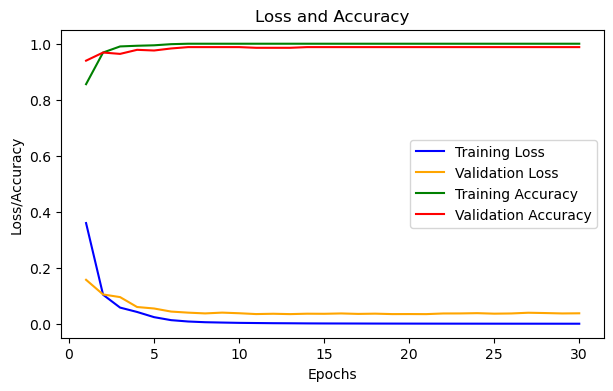

In [68]:
plot_loss_and_accuracy(history)

39/39 [==============================] - 16s 385ms/step
Training Accuracy = 1.00


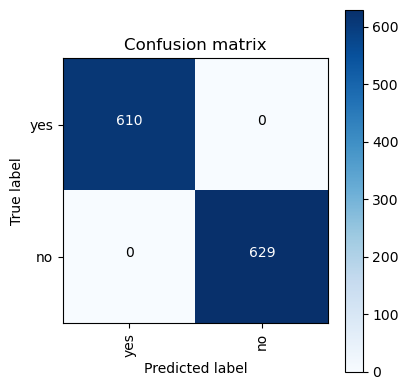

In [69]:
labels = ['yes','no']
# Prediction on traning set
predictions = model.predict(X_train)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_train, predictions)
print('Training Accuracy = %.2f' % accuracy)
confusion_Maritx = confusion_matrix(y_train, predictions) 
cm = plot_Confusion_Matrix(confusion_Maritx, classes = labels, normalize=False)

13/13 [==============================] - 5s 367ms/step
Val Accuracy = 0.99


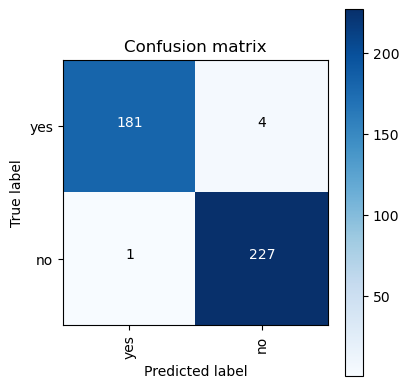

In [70]:

labels = ['yes','no']
# Prediction on val set
predictions = model.predict(X_val)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %.2f' % accuracy)

confusion_Matrix = confusion_matrix(y_val, predictions) 
cm = plot_Confusion_Matrix(confusion_Matrix, classes = labels, normalize=False)

13/13 [==============================] - 5s 374ms/step
Test Accuracy = 0.99


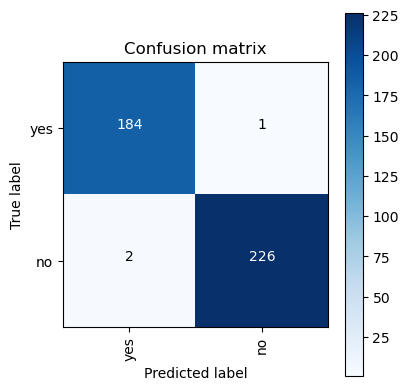

In [71]:
# Prediction on test set
predictions = model.predict(X_test)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

confusion_Matrix = confusion_matrix(y_test, predictions) 
cm = plot_Confusion_Matrix(confusion_Matrix, classes = labels, normalize=False)

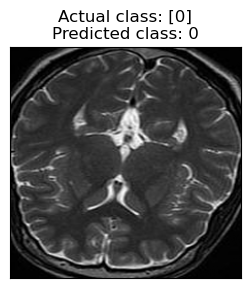

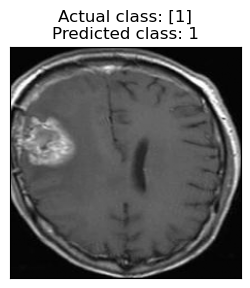

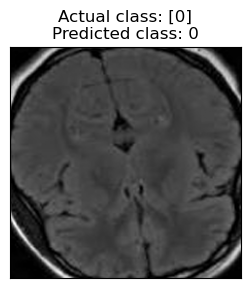

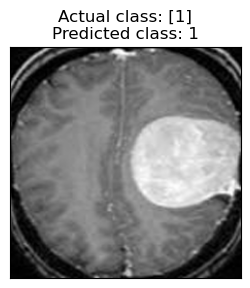

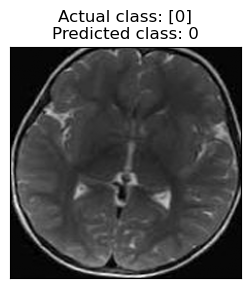

In [72]:
for i in range(5):
    plt.figure(figsize=(3,3))
    plt.imshow(X_test[i])
    plt.xticks([])
    plt.yticks([])
    plt.title(f'Actual class: {y_test[i]}\nPredicted class: {predictions[i]}')
    plt.show()

In [73]:
# Classification Report of MobileNet Model
report5 = classification_report(y_test, predictions)
print(report5)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       185
           1       1.00      0.99      0.99       228

    accuracy                           0.99       413
   macro avg       0.99      0.99      0.99       413
weighted avg       0.99      0.99      0.99       413



# Comparing model between real and augmentaed database

In [111]:
def extract_metrics(report):
    # Parse the classification report into a dictionary
    report_data = {}
    lines = report.split('\n')
    
    for line in lines:
        row = line.split()
        if len(row) == 0:
            continue  # Skip empty lines
        if len(row) == 5:
            class_name, precision, recall, f1_score, support = row
            report_data[class_name] = {
                'precision': float(precision),
                'recall': float(recall),
                'f1_score': float(f1_score),
                'support': int(support)
            }
        elif len(row) == 6 and row[0].isdigit():  # Check if it matches the expected format
            # Sometimes classification report adds a space which creates an extra column
            class_name = row[0]
            precision = row[1]
            recall = row[2]
            f1_score = row[3]
            support = row[4]
            report_data[class_name] = {
                'precision': float(precision),
                'recall': float(recall),
                'f1_score': float(f1_score),
                'support': int(support)
            }
    
    # Extracting accuracy directly from the report
    for line in lines:
        if "accuracy" in line:
            accuracy = float(line.split()[1])
            report_data['accuracy'] = accuracy
            break

    return report_data





In [112]:
# Extract metrics from the classification reports
CNN_real_data_matrics= extract_metrics(report1)
CNN_aug_data_matrics = extract_metrics(report2)
VGG_matrics= extract_metrics(report3)
Inception_matrics = extract_metrics(report4)
Mobilenet_matrics= extract_metrics(report5)



In [113]:
# Prepare the data for plotting
metrics = ['accuracy', 'precision', 'recall', 'f1_score']
CNN_real_data_values = [CNN_real_data_matrics['accuracy'],
                    CNN_real_data_matrics['1']['precision'],
                    CNN_real_data_matrics['1']['recall'],
                    CNN_real_data_matrics['1']['f1_score']]

CNN_aug_data_values = [CNN_aug_data_matrics['accuracy'],
                         CNN_aug_data_matrics['1']['precision'],
                         CNN_aug_data_matrics['1']['recall'],
                         CNN_aug_data_matrics['1']['f1_score']]

VGG_values = [VGG_matrics['accuracy'],
                    VGG_matrics['1']['precision'],
                    VGG_matrics['1']['recall'],
                    VGG_matrics['1']['f1_score']]

Inception_values = [Inception_matrics['accuracy'],
                         Inception_matrics['1']['precision'],
                         Inception_matrics['1']['recall'],
                         Inception_matrics['1']['f1_score']]

Mobilenet_values = [Mobilenet_matrics['accuracy'],
                    Mobilenet_matrics['1']['precision'],
                    Mobilenet_matrics['1']['recall'],
                    Mobilenet_matrics['1']['f1_score']]



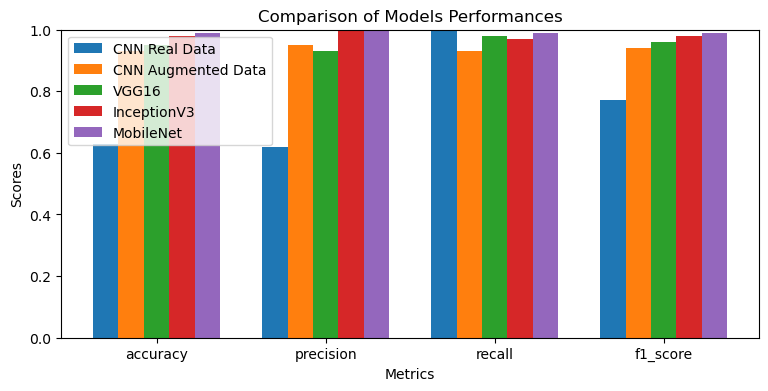

In [115]:

# Position of bars on x-axis
x = np.arange(len(metrics))

# Width of each bar
bar_width = 0.15

# Plotting
plt.figure(figsize=(9, 4))

# Plot bars for each model
plt.bar(x - 2*bar_width, CNN_real_data_values, width=bar_width, label='CNN Real Data')
plt.bar(x - bar_width, CNN_aug_data_values, width=bar_width, label='CNN Augmented Data')
plt.bar(x, VGG_values, width=bar_width, label='VGG16')
plt.bar(x + bar_width, Inception_values, width=bar_width, label='InceptionV3')
plt.bar(x + 2*bar_width, Mobilenet_values, width=bar_width, label='MobileNet')

# Adding labels and title
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Comparison of Models Performances')
plt.xticks(x, metrics)
plt.ylim(0, 1) 
plt.legend()

# Display the plot
plt.show()


Evaluation: VGG-16 was used for transfer learning on augmented data. This model was refined on the big ImageNet dataset and achieved 95% test accuracy with 94% and 96% fi-score for class 0 and 1, respectively. Subsequently, InceptionV3 was used to try and get a better result; for both classes, it achieved 98% F1-score and 98% test accuracy. While the accuracy of these two frameworks (VGG-16 and GoogleNet) is higher, they are useful in classifying tumors; Lastly, I decided to employ MobileNet, another pre-trained model that is renowned for producing outstanding results due to its lightweight architecture. In testing, I obtained 99% accuracy and an F1-score of 99%.